In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scipy

# %matpnlotlib notebook 
%matplotlib inline 

In [2]:
import qutip as qutip

# https://qutip.readthedocs.io/en/latest/guide/guide.html
# https://qutip.org/qutip-tutorials/

fileroot = 'walk_03_'

In [3]:
# check to see if an np.array square matrix is unitary 
def is_unitary(m):
    bb = np.allclose(np.eye(len(m)), m.dot(m.T.conj()), rtol=1e-05, atol=1e-08) # for square numpy array m
    return bb  # returns boolean
    
# given a Hermitian operator qutip.Qobj Hop on a 2 state system
# create an tensor product n_qubit unitary that is identity except j, j+1 qubits
# were we put the operator e^(i epsilon Hop)
# does not use any globals
def mk_interaction_small(n_qubits,Hop,epsilon,j):
    if (j <0):
        print('err j<0')
        return 0
    if (j > n_qubits-2):
        print('err j<n_qubits-2')
        return 0
    if (Hop.check_herm() != True):
        print('mk_interaction_small: Warning: Hop is not Hermitian')
    #small_op = 1j*epsilon*Hop  # e^(i epsilon Hop)
    U_small_np = scipy.linalg.expm(1j*epsilon*Hop.full())  # make a small near identity transformation 
    # using scipy's expm with the hope that it will more likely to be actually unitary, the result is a numpy array 
    #U_small =  qutip.Qobj(U_small_np,dims = [[2, 2], [2, 2]],isunitary=True)
    U_small =  qutip.Qobj(U_small_np,dims = [[2, 2], [2, 2]])
    if (U_small.isunitary != True):
        print('mk_interaction_small: U_small is not unitary')
    # now we make embed the interaction in the full tensor product space 
    id2 = qutip.qeye(2)  # identity 
    op_list = []  # create a list of operators 
    for k in range(0,j):
        op_list = np.append(op_list,id2)
    op_list = np.append(op_list,U_small)
    for k in range(j+2,n_qubits):
         op_list = np.append(op_list,id2)
    U_int = qutip.tensor(op_list)  # tensor product 
    if (U_int.isunitary != True):
        print('mk_interaction_small: U_int is not unitary')
    return U_int

if (1==0):  # tests 
    #create a swap gate for 2 qubits 
    #|ij> \to |ji> 
    # is both hermitian and unitary 
    Qswap = qutip.Qobj([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
         dims = [[2, 2], [2, 2]],
        isherm=True,
        isunitary=True)
    print(Qswap)
    epsilon=0.1
    n_qubits = 5
    U_int0 = mk_interaction_small(n_qubits,Qswap,epsilon,n_qubits-2)
    print(U_int0)
    print(U_int0.isunitary)
    print(is_unitary(U_int0.full()))
    

In [4]:
# make the two Kraus operators we need for a reset operation on a single qubit 
# returns 2 qutip.Qobj 
def mkKraus_reset():
    ket0 = qutip.basis(2, 0) # |0>
    ket1 = qutip.basis(2, 1) # |1>
    K0 = ket0*ket0.dag() #|0><0|
    K1 = ket0*ket1.dag() #|0><1|
    return K0,K1

# Make the 2 Kraus operators needed for a full n_qubit system 
# resturns 2 qutip.Qobj operators 
# but reseting only j-th qubit 
# uses above routine mkKraus_reset()
def mk_Kreset(n_qubits,j):
    K0,K1 = mkKraus_reset() # get the 2 1 bit kraus ops
    id2 = qutip.qeye(2)  # identity op
    op_list0 = []
    op_list1 = []
    for k in range(0,j):
        op_list0 = np.append(op_list0,id2)  # load up identities until j index 
        op_list1 = np.append(op_list1,id2)  
    op_list0 = np.append(op_list0,K0) 
    op_list1 = np.append(op_list1,K1) 
    for k in range(j+1,n_qubits):
        op_list0 = np.append(op_list0,id2)  # load up identities until last index 
        op_list1 = np.append(op_list1,id2)  
    K0_big = qutip.tensor(op_list0)
    K1_big = qutip.tensor(op_list1)
    return K0_big,K1_big

showit = 0  # tests!
if (1==showit):
    K0,K1 = mkKraus_reset()
    print(K0,K1)

if (1==showit):
    n_qubits=5
    K0_big,K1_big = mk_Kreset(n_qubits,0)
    print(K0_big,K1_big)


In [11]:
# random op on first qubit
# reset on last qubit
# in between exponentially small versions of an operator that we pass  
# calls above routines mk_Kreset(), mkKraus_reset(), mk_interaction_small()
class walkit():
    # init: arguments:
    #  n_qubits:  number of qubits
    #  epsilon:  strength of 2qubit local interaction 
    #  H_2bits:  Hermitian 2qubit interaction operator qutip.Qobj
    #  sim_label:  a string label for simulation
    def __init__(self,n_qubits,epsilon,H_2bits,sim_label):
        self.n_qubits = n_qubits  # number of qubits
        self.N = 2**n_qubits
        self.epsilon = epsilon  # perturbation parameter 
        self.H_2bits = H_2bits  # Hermitian op qutip.Qobj
        self.sim_label = sim_label  # a string label 

        # make Kraus operators for reset on last qubit 
        K0_big,K1_big = mk_Kreset(self.n_qubits,self.n_qubits-1)    # external routine 
        self.K0_big = K0_big # store the Kraus operators (n_qubit system)  qutip.Qobj
        self.K1_big = K1_big 
        self.S0 = qutip.sprepost(K0_big,K0_big.dag())  # superoperators 
        self.S1 = qutip.sprepost(K1_big,K1_big.dag())
        
        self.init_rho()  # initialize to the ground state, makes self.rho
        self.mk_int_prod()  # make an interaction unitary  self.U_int_prod  using self.epsilon and self.H_2bits

    # create density operator from ground state in all qubits 
    # creates self.rho
    def init_rho(self):
        ket0 = qutip.basis(2, 0)
        op_list = []
        for j in range(self.n_qubits):
            op_list = np.append(op_list,ket0)
        psi  = qutip.tensor(op_list) # this is a ket, not an operator 
        self.rho = qutip.ket2dm(psi)  # make density operator from statevector psi
        self.rho_init = self.rho  # keep a copy
        
    # make an interaction unitary of a product of nearidentity operators based on a 2 qubit operator self.H_2bits
    # creates self.U_int_prod
    # this is a sequential product of 2qubit operators 
    def mk_int_prod(self):
        U_int_prod  = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon,0) # external routine 
        # this is a n_qubit operator that has e^{i epsilon H_2bits} operating on first two qubits
        # and is identity in the rest 
        for j in range(1,self.n_qubits-1):  # from 1 to n-1
            U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon,j)    # sequential local interactions
            U_int_prod = U_int*U_int_prod   # is a product of all these interactions operators 
        self.U_int_prod = U_int_prod  # returns nothing, creates self.U_int_prod
        if (self.U_int_prod.isunitary != True):
            print('warning: U_int_prod is not unitary!')
                  
    # first do random, then interactions, then reset, then update rho
    def do_channel(self,use_super=False,do_checks=False):
        U_rand = self.create_rand_op(0) # random op in first qubit, internal routine 
        # U_rand must be remade every time this routine is called 
        U_tot = self.U_int_prod*U_rand  # interactions after random op 
        if (do_checks == True):
            bb = is_unitary(U_tot.full())
            #if (U_tot.isunitary != True):
            if (bb != True):
                print('warning: U_tot not unitary')

        # bombs!
        if (use_super == True) :     #This does not work at all, too slow or something 
            rho_vec = qutip.operator_to_vector(self.rho) # vector form for rho
            S_U_tot = qutip.sprepost(U_tot, U_tot.dag()) # superoperator 
            # interactions and random operator applied to density operator 
            new_rho_vec = S_U_tot *rho_vec 
            # apply reset channel 
            new_rho2_vec = (self.S0 + self.S1) *new_rho_vec  # using superoperators 
            new_rho2 = qutip.vector_to_operator(new_rho2_vec) 

        else: 
            U_tot_dagger = U_tot.dag()
            # interactions and random operator applied to density operator 
            new_rho = U_tot*(self.rho*U_tot_dagger)  # unitary evolution of density operator 
            # apply reset channel 
            new_rho2  = self.K0_big*(new_rho*self.K0_big.dag()) + self.K1_big*(new_rho*self.K1_big.dag()) 
            #trrho = np.trace(new_rho2.full())  #let's see if this works to prevent instability 
            #new_rho2 = new_rho2/trrho  
        
        self.rho = new_rho2  # update density operator 
        #print(np.trace(self.rho.full()))

    # iterate ntimes x nstore
    # store traced density operators nstore times 
    def iterate(self,ntimes,nstore,use_super=False,do_checks=False):
        rho_store = np.zeros([nstore,self.n_qubits,2,2],dtype=complex)
        mx_store = np.zeros([nstore,self.n_qubits])
        my_store = np.zeros([nstore,self.n_qubits])
        mz_store = np.zeros([nstore,self.n_qubits])
        for k in range(nstore):
            for m in range(ntimes):  # iterate ntimes 
                self.do_channel(use_super=use_super,do_checks=do_checks)
            for j in range(self.n_qubits):
                rho_j = self.rho.ptrace(j)  # partial trace all qubits but the jth one
                rho_store[k,j,:,:] = rho_j.full()  # try to store each partial trace 
                mx = np.real( (rho_j*qutip.sigmax()).tr())  # measure x,y,z in each qubit
                my = np.real( (rho_j*qutip.sigmay()).tr())  #
                mz = np.real( (rho_j*qutip.sigmaz()).tr())
                mx_store[k,j] = mx
                my_store[k,j] = my
                mz_store[k,j] = mz
            if (do_checks==True):
                rhot = np.trace(self.rho.full())
                if (rhot > 1.2):
                    print('warning: trace rho >1.2')  # if you have screwed up badly!
                    break
        self.rho_store = rho_store
        self.mx_store = mx_store
        self.my_store = my_store
        self.mz_store = mz_store
        self.ntimes = ntimes
        self.nstore = nstore

    # create a unitary operator that is a tensor product of identity on all qubits but the j-th one 
    # and is random Haar on the j-th one
    # indexing j=0 to n_qubits-1
    # does not use any globals
    # returned operater is a unitary on full n_qubit system
    def create_rand_op(self,j):
        id2 = qutip.qeye(2)  # identity on a single qubit 
        R2 = qutip.random_objects.rand_unitary(2)  # Haar random on 2 state  (single qubit)
        op_list = []  # create a list of operators  that is n_qubits long
        for k in range(0,j):
            op_list = np.append(op_list,id2)  # insert identities 
        op_list = np.append(op_list,R2)  # put in the random op
        for k in range(j+1,self.n_qubits):
            op_list = np.append(op_list,id2) # more identities 
        U_rand = qutip.tensor(op_list)   # tensor product of n_qubit number of 2 state systems 
        return U_rand

In [12]:
# make a figure showing <sigma_z> for each qubit (tracing out the others)
def sigz_fig(sim,i0):
    colorlist = ['red','orange','gold','green','blue','violet']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])
    nit = np.arange(len(mz0))
    for j in range(sim.n_qubits):
        mz = np.squeeze(sim.mz_store[0:,j])
        print(np.mean(mz[i0:]),np.std(mz[i0:]))
        ax.plot(nit,mz,'.',color=colorlist[j%nc],ms=1)
    ax.set_xlabel('iteration')
    ax.set_ylabel(r'$\langle \sigma_z \rangle$ each qubit',labelpad=-3)
    ofile = fileroot+sim.sim_label+'_sz.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()



In [13]:
# make a 2 qubit swap operator 
Qswap = qutip.Qobj([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
            dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)
#Qswap.full() gives array

# this is the same thing as sigma_+^0 sigma_-^2 + sigma_-^0 sigma_+^2
Qswap_short = qutip.Qobj([[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]],
            dims = [[2, 2], [2, 2]],
            isherm=True)  # notice no terms on diagonal, is not unitary

# controlled not with first bit the control bit 
QCnotC0 =  qutip.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
            dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)

# controlled not with second bit the control bit 
QCnotC1 =  qutip.Qobj([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]],
             dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)

# the Heisenberg spin interaction (sum of pairs of Paulis)
# this is the same thing as sigma_+^1 sigma_-^2 + sigma_-^1 sigma_+^2 + sigma_z^1 sigma_z^2
# which is sum_i sigma_i^1 sigma_i^2
QHeis = qutip.Qobj([[1, 0, 0, 0], [0, -1, 2, 0], [0, 2, -1, 0], [0, 0, 0, 1]],
            dims = [[2, 2], [2, 2]], isherm=True)

if (1==0):  # test
    print(Qswap)
    print(Qswap_short)
    print(QCnotC0)
    print(QCnotC1)

if (1==0):  # tests
    print(QHeis)
    #qutip.tensor([QHeis,QHeis])
    n_qubits=5; epsilon = 0.1; j=0
    U_int = mk_interaction_small(n_qubits,QHeis,epsilon,j)
    small_op = 1j*epsilon*QHeis  # e^(i epsilon Hop)
    #print(small_op.isherm)
    U_small_np = scipy.linalg.expm(1j*epsilon*QHeis.full())  # make a small near identity transformation 
    # using scipy's expm with the hope that it will more likely to be actually unitary, the result is a numpy array 
    U_small =  qutip.Qobj(U_small_np,dims = [[2, 2], [2, 2]])
    print(U_small.isunitary)
    QHeis.check_herm() 

0.0003856450648483234 0.14091645665932456
0.3940229761489754 0.12774786497474291
0.4802498120799205 0.10875718006764722
0.551940799586148 0.0974527358299146
0.637066358454279 0.08009149466630446
1.0000000000009552 6.397763378673041e-13
walk_03_S7_sz.png


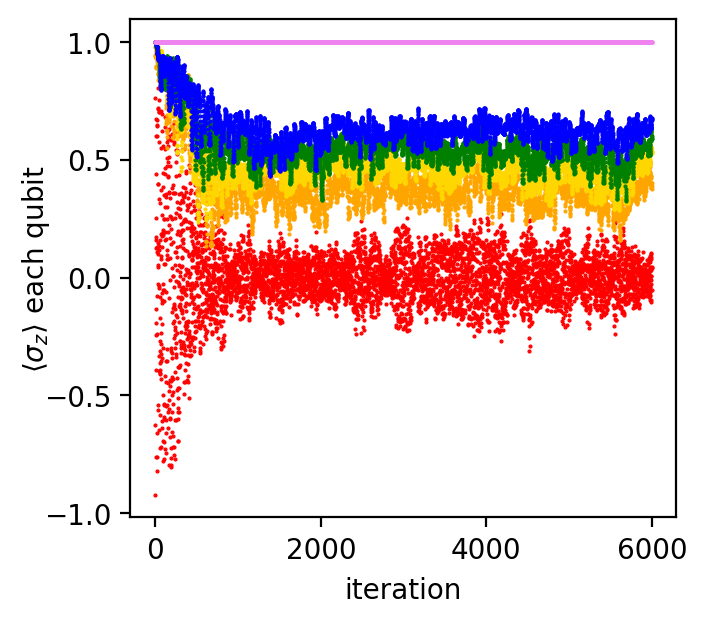

In [14]:
n_qubits = 6
epsilon = 0.05;
sim_label = 'S7'
mtimes = 1 
nstore = 400*15
sim7 = walkit(n_qubits,epsilon,QHeis,sim_label) # 
#for i in range(2):
#    sim7.do_channel()
sim7.iterate(mtimes,nstore,use_super=False)  #   use_super=True bombs 
sigz_fig(sim7,0)

0.004630860220914498 0.11293649041032501
0.37050809235879256 0.0689828136221406
0.460168309414842 0.051650277534617636
0.5407112976855785 0.05054192279243178
0.6268919853404993 0.05159381153621316
0.9999999999988712 4.294806703490139e-13
walk_03_S1_sz.png


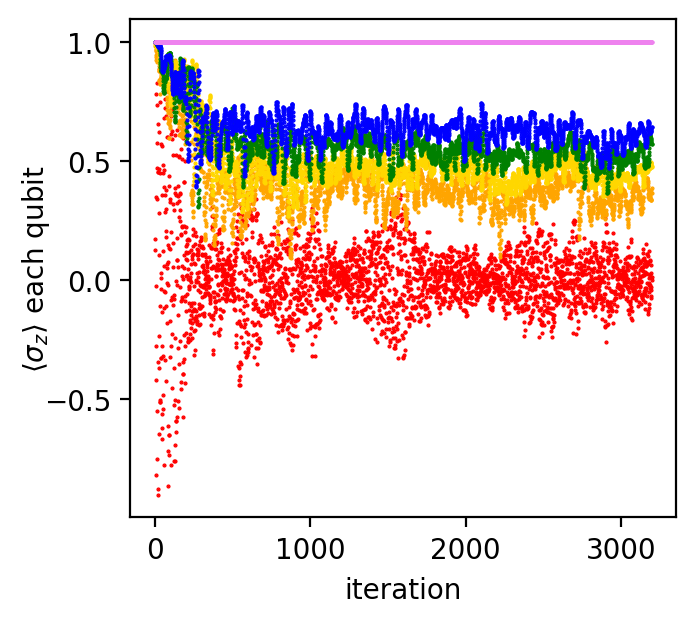

In [15]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1'
sim1 =  walkit(n_qubits,epsilon,Qswap,sim_label)
mtimes = 1 
nstore = 400*8
sim1.iterate(mtimes,nstore)  # 
sigz_fig(sim1,500)

0.0011007646482150662 0.15249568987272494
0.433524360177871 0.11592664507912497
0.5171635780854562 0.10561014120072626
0.5840604928617539 0.09388553699034985
0.6749932365808736 0.07141763902833695
1.00000000000115 6.96907919315695e-13
walk_03_S2_sz.png


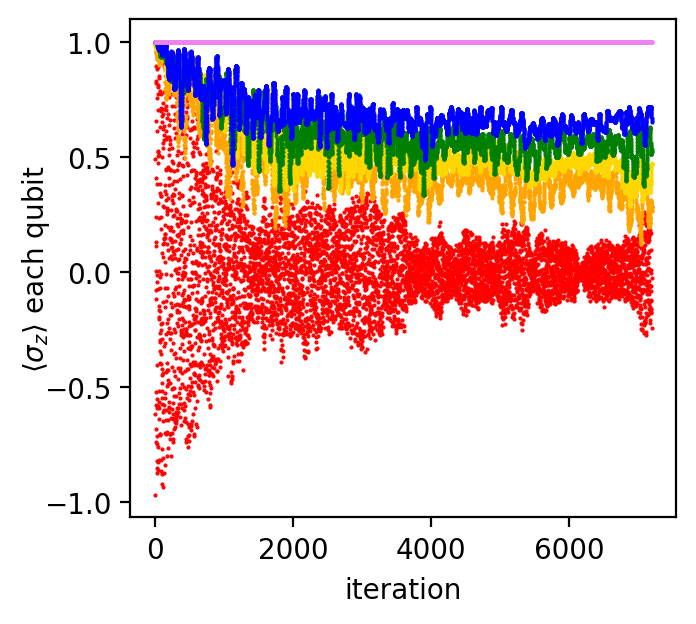

In [16]:
n_qubits = 6
epsilon = 0.05;
sim_label = 'S2'
mtimes = 1 
nstore = 400*18
sim2 =  walkit(n_qubits,epsilon,Qswap,sim_label)
sim2.iterate(mtimes,nstore)  # 
sigz_fig(sim2,500)

walk_03_S1_szmov.png


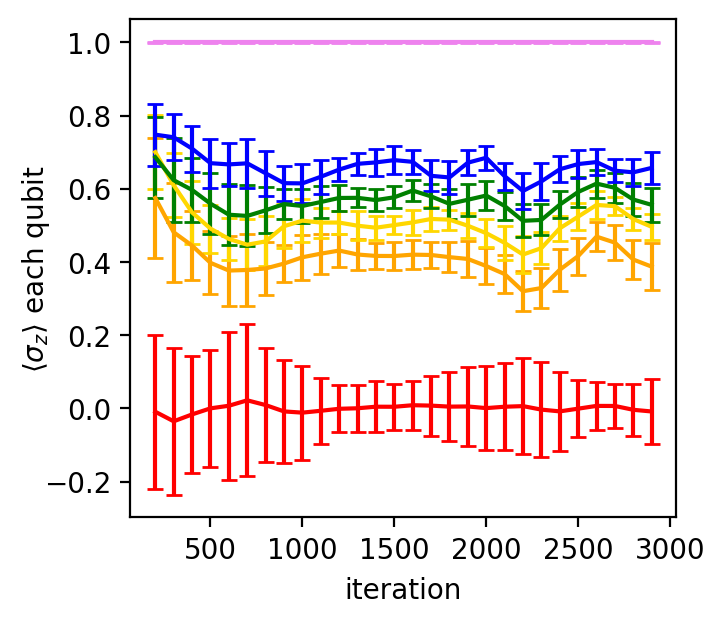

walk_03_S2_szmov.png


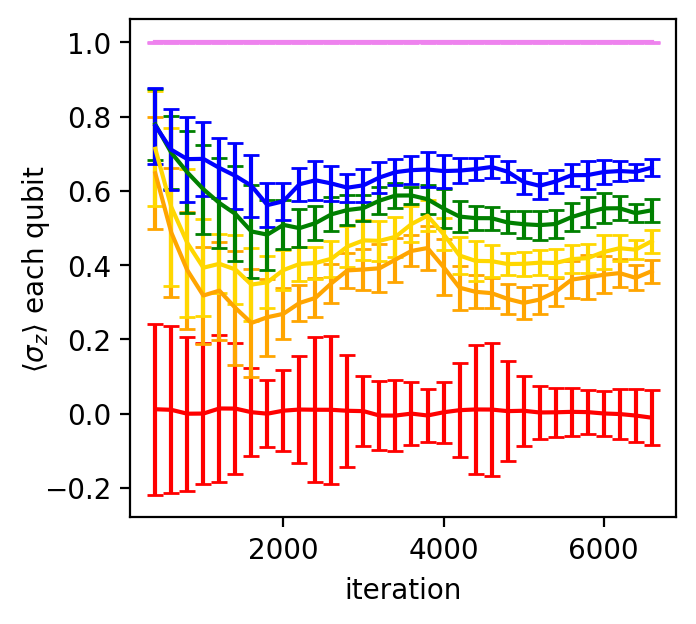

In [42]:
# series is a 1 array, d is a window length (integer)
# make a moving average of both mean and dispersion around mean
from scipy import ndimage
def stats_window(series,dwindow):
    ns = len(series)
    moving_ave = ndimage.uniform_filter(series, size=dwindow,mode='constant')
    remainder = (series - moving_ave)**2
    moving_sig2 = ndimage.uniform_filter(remainder, size=dwindow,mode='constant')
    moving_sig = np.sqrt(moving_sig2+1e-6)
    return moving_ave,moving_sig

def sigz_moving_fig(sim,dwindow):
    colorlist = ['red','orange','gold','green','blue','violet']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])
    nit = np.arange(len(mz0))
    di=int(dwindow/2)
    for j in range(n_qubits):
        mz = np.squeeze(sim.mz_store[0:,j])
        moving_ave,moving_sig = stats_window(mz,dwindow)
        #print(np.mean(mz[i0:]),np.std(mz[i0:]))
        #ax.plot(nit,mz,'.',color=colorlist[j%nc],ms=1)
        plt.errorbar(nit[2*di:-2*di:di],moving_ave[2*di:-2*di:di],yerr=moving_sig[2*di:-2*di:di],capsize=3,color=colorlist[j%nc])
    ax.set_xlabel('iteration')
    ax.set_ylabel(r'$\langle \sigma_z \rangle$ each qubit',labelpad=-3)
    ofile = fileroot+sim.sim_label+'_szmov.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

sigz_moving_fig(sim1,200)
sigz_moving_fig(sim2,400)

0.0016376139099595977 0.11633021207207739
0.151608319930675 0.08668432550611416
0.18955710604806167 0.08078979618600006
0.2799950594623723 0.08885995197735379
0.47467810812632605 0.07750561842814388
0.9999999999992795 3.0292908502115183e-13
walk_03_S3_sz.png


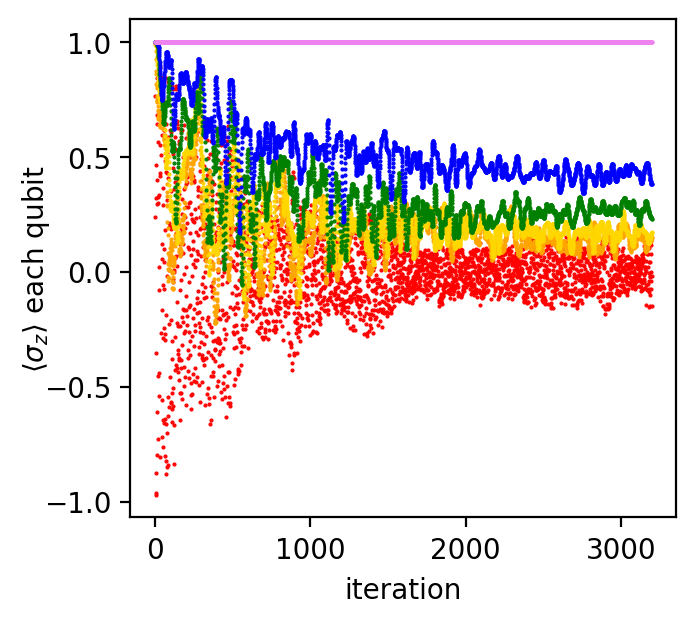

In [17]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S3'
sim3 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC0,sim_label)
#junk1.do_channel()
mtimes = 1 
nstore = 400*8
sim3.iterate(mtimes,nstore)  # 
sigz_fig(sim3,500)

0.0009977222550743398 0.12827095867004465
0.11262280540140841 0.0649290577564203
0.1544347320748384 0.07802752213627392
0.18396002460837416 0.06515840027838805
0.2984075326630738 0.07761504118235384
0.9999999999993631 2.4584765328144787e-13
walk_03_S4_sz.png


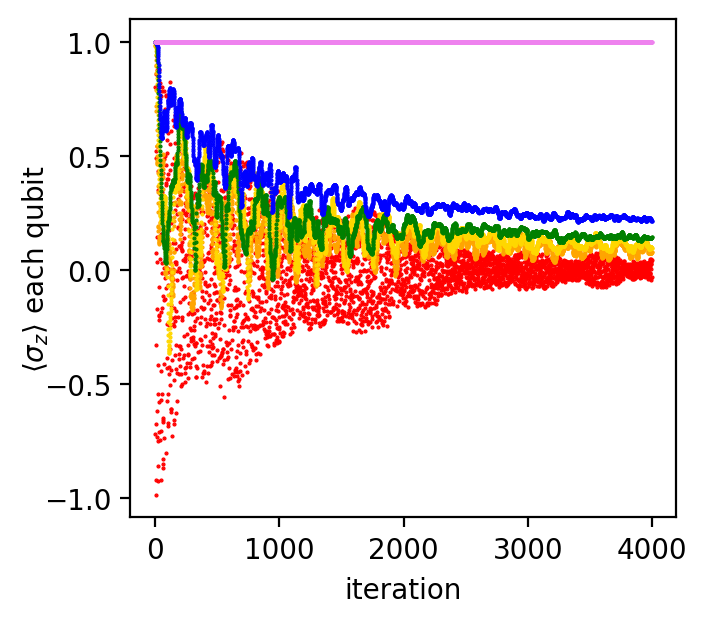

In [18]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S4'
mtimes = 1 
nstore = 400*10
sim4 =  walkit(n_qubits,epsilon,0.2*Qswap+0.8*QCnotC0,sim_label)
#junk1.do_channel()
sim4.iterate(mtimes,nstore)  # 
sigz_fig(sim4,500)

0.0015452527265299193 0.13363297532158377
0.2900483894394576 0.09934908361215403
0.25997476224457006 0.09032824446351871
0.28425009122188644 0.10016888944515229
0.4181716738296318 0.08983283520324764
1.0 1.805513236600925e-16
walk_03_S5_sz.png


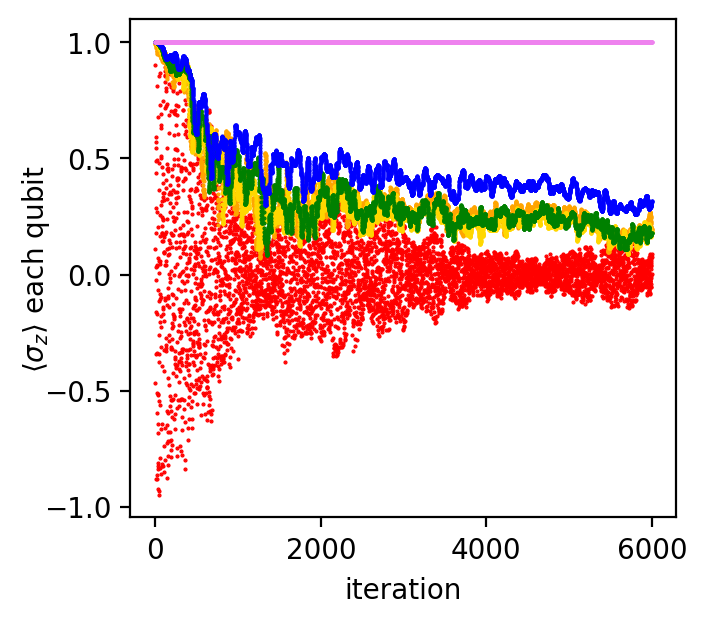

In [21]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S5'
mtimes = 1 
nstore = 400*15
sim5 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC1,sim_label)
#junk1.do_channel()
sim5.iterate(mtimes,nstore)  # 
sigz_fig(sim5,500)

0.0041867162746669845 0.21213466220108038
0.5193514134995871 0.15326642141408978
0.5214835328811721 0.13636764376186084
0.5207136626453319 0.13687014735800213
0.5233837450128402 0.14740653968777193
1.0 1.864141070515652e-16
walk_03_S6_sz.png


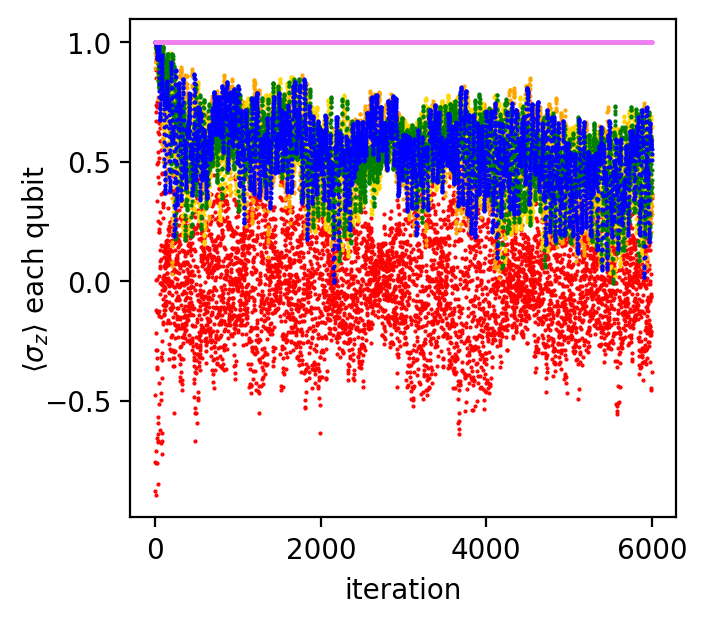

In [22]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S6'
mtimes = 1 
nstore = 400*15
sim6 =  walkit(n_qubits,epsilon,Qswap_short,sim_label)
sim6.iterate(mtimes,nstore)  # 
sigz_fig(sim6,500)

In [23]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S7'
mtimes = 1 
nstore = 400*15
sim7 = walkit(n_qubits,epsilon,QHeis,sim_label)
sim7.do_channel()
#sim7.iterate(mtimes,nstore)  # 
#sigz_fig(sim7,500)

0.008278452252362591 0.2348370040638718
0.520943116599222 0.16084819637197642
1.0 1.0433089591669239e-16
walk_03_T1_sz.png


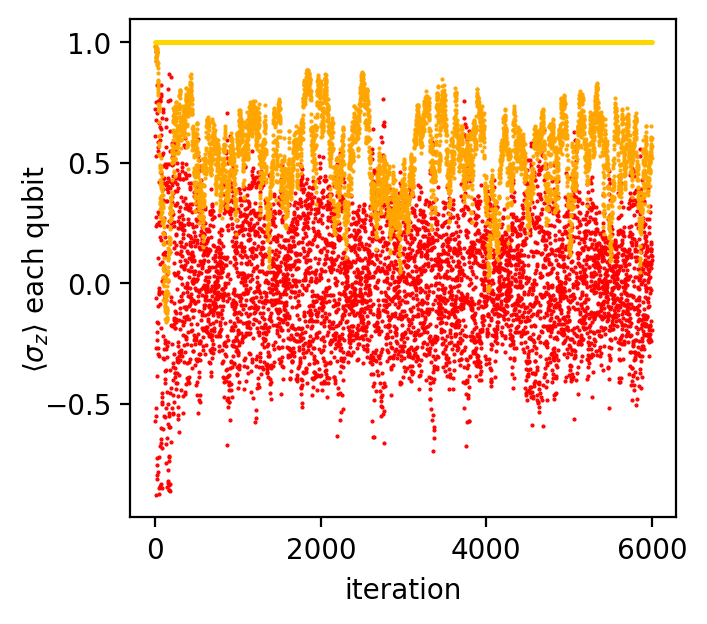

In [24]:
n_qubits = 3
epsilon = 0.1;
sim_label = 'T1'
mtimes = 1 
nstore = 400*15
tsim1 =  walkit(n_qubits,epsilon,1.0*Qswap+0.0*QCnotC0,sim_label)
tsim1.iterate(mtimes,nstore)  # 
sigz_fig(tsim1,500)

0.0005774545396559916 0.27373965675317
0.44919193298601007 0.16244509569959056
1.0 1.0219681840978395e-16
walk_03_T2_sz.png


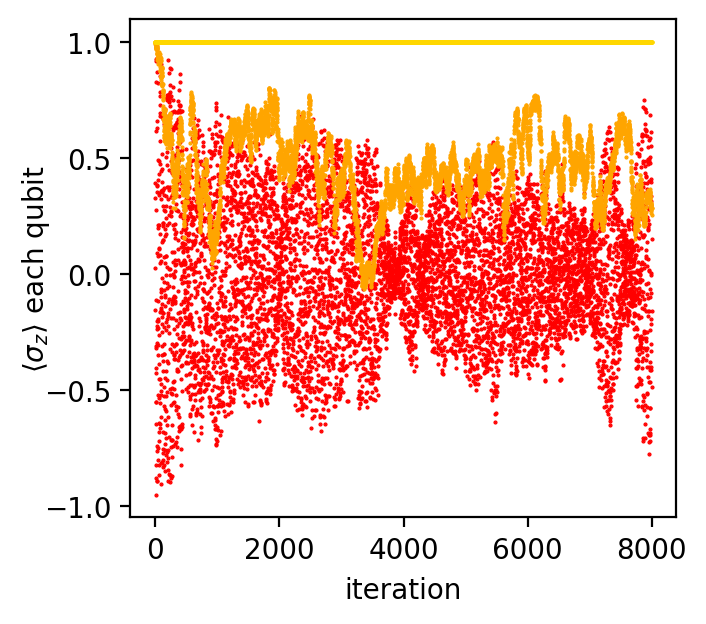

In [25]:
n_qubits = 3
epsilon = 0.05;
sim_label = 'T2'
mtimes = 1 
nstore = 400*20
tsim2 =  walkit(n_qubits,epsilon,1.0*Qswap+0.0*QCnotC0,sim_label)
tsim2.iterate(mtimes,nstore)  # 
sigz_fig(tsim2,500)

0.0009273430876544154 0.2147095125968403
0.348319143993072 0.16572754577721685
0.9999999999991364 4.3806219640886056e-13
walk_02_T3_sz.png


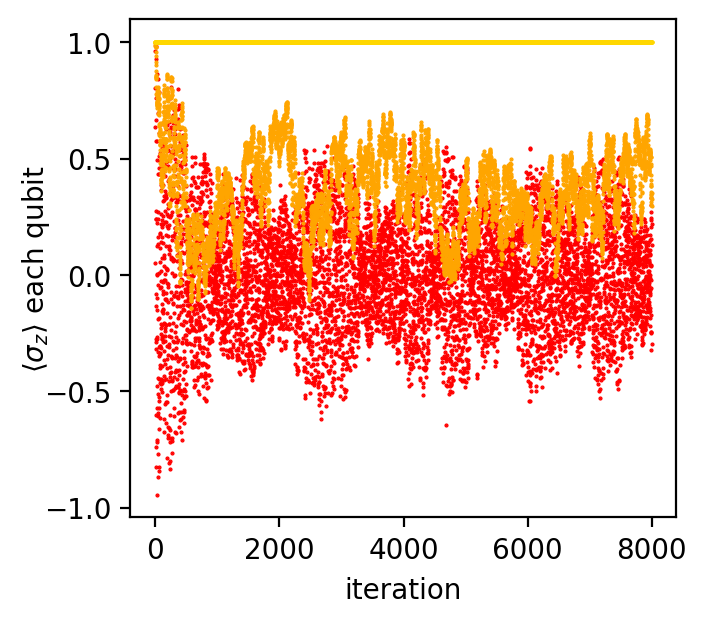

In [107]:
n_qubits = 3
epsilon = 0.05;
sim_label = 'T3'
mtimes = 1 
nstore = 400*20
tsim3 =  walkit(n_qubits,epsilon,1*Qswap+1*QCnotC0,sim_label)
tsim3.iterate(mtimes,nstore)  # 
sigz_fig(tsim3,500)

## everything below is garbage for testing 

In [35]:
ket0 = qutip.basis(2, 0) # |0>
ket1 = qutip.basis(2, 1) # |1>
psi = (ket0 + 0.1j*ket1).unit()
rho = psi * psi.dag()
rho_vec = qutip.operator_to_vector(rho)
K0,K1 = mkKraus_reset()
#S = sum([qutip.sprepost(P, P) for P in (K0, K1)]) 
#print(S)
#print(S*rho_vec) # I don't know how to apply a quantum operator 
S0 = qutip.sprepost(K0,K0.dag())
S1 = qutip.sprepost(K1,K1.dag())

new_rho_vec = (S0 + S1)*rho_vec 
print(new_rho_vec)
# vector_to_operator exists!
new_rho = qutip.vector_to_operator(new_rho_vec)
print(new_rho)

Quantum object: dims=[[[2], [2]], [1]], shape=(4, 1), type='operator-ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0.]
 [0. 0.]]
